Selecting the Most Important Features
===

<div class="alert alert-block alert-info">
Author: Nathan A. Mahynski

Date: 2023/08/31

Description: Examples of different ways to select important features for modeling.
</div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git --depth 1
    !cd pychemauth; pip3 install .; cd ..

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import numpy as np
import pandas as pd

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

sklearn   : 1.3.0
json      : 2.0.9
numpy     : 1.24.4
watermark : 2.4.3
pandas    : 2.0.3
pychemauth: 0.0.0b3
matplotlib: 3.7.2



<div class="alert alert-block alert-info"> 
One way to select relevant features is based on statistical correlation or mutual information between the X column and the target y.  <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection">scikit-learn has a number of tools for this</a>; certain models, like random forests, have feature importances that can be used to remove features which are considered important for a model. However, a more direct way is simply to test which variables actually improve the performance of the final model.  All this requires a model which returns some score (e.g., R^2 for regression or accuracy for classification).
</div>

Here, we will explore how to use the latter inside pipelines, enabling automatic feature selection with various strategies.

<h3>Load the data</h3

Load some example data downloaded from Kaggle [here]()https://www.kaggle.com/datasets/mathchi/hitters-baseball-data?select=Hitters.csv

In [4]:
# df = pd.read_csv('../data/Hitters.csv')

# # Let's do a little clean up and only select the numerical columns.
# df = df.select_dtypes(include=np.number).dropna()

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     df.iloc[:,:-1].values,
#     df['Salary'].values, # Let's try to predict the salary based on the other numerical features.
#     shuffle=True,
#     random_state=42,
#     test_size=0.2
# )

# from pychemauth.preprocessing.scaling import CorrectedScaler

# scaler = CorrectedScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [5]:
from sklearn.datasets import load_wine as load_data
X, y = load_data(return_X_y=True, as_frame=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, 
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y
)

from pychemauth.preprocessing.scaling import CorrectedScaler

scaler = CorrectedScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LASSO
--

As a baseline, let's build a simple linear regression model with an <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html">L1 (LASSO)</a> penalty.  These models have sparse solutions meaning that features which do not contribute significantly to the model have their coefficients set to zero, eliminating them.

This is meant for regression tasks not classification (which are doing here), but for illustration we can try to regress the class which is encoded as an integer.

In [114]:
from sklearn.linear_model import Lasso

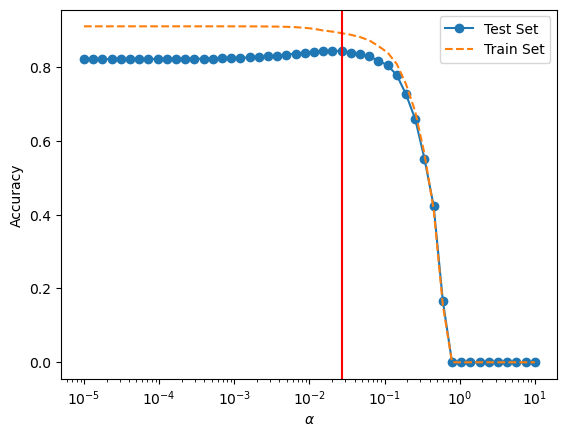

In [274]:
# When alpha = 0 we have a simple linear regression case.  Otherwise, this multiplies the L1 penalty.
alpha_values = np.logspace(-5, 1, 50)
test_score, train_score = [], []

for alpha in alpha_values:
    model = Lasso(
        alpha=alpha,
        fit_intercept=True, 
        copy_X=True, 
        max_iter=10000, 
        tol=0.0001, 
        random_state=42, 
        selection='cyclic'
    )
    
    _ = model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
plt.plot(alpha_values, test_score, 'o-', label='Test Set')
plt.plot(alpha_values, train_score, '--', label='Train Set')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel(r'$\alpha$')
plt.legend(loc='best')

best_alpha = alpha_values[np.argmax(test_score)]
_ = plt.axvline(best_alpha, color='red')

The best alpha value is based on the test set performance boost.  When alpha approaches 0 all features are kept. Here we can see that eliminating variables starts to lead to an increase in model performance, then a decay as too many are eliminated.  The best alpha leads to the peak.

In [275]:
model = Lasso(
    alpha=best_alpha,
    fit_intercept=True, 
    copy_X=True, 
    max_iter=10000, 
    tol=0.0001, 
    random_state=42, 
    selection='cyclic'
)
    
_ = model.fit(X_train, y_train)

In [280]:
# The coefficients non-zero values have been removed from the model
print('Coef. \t Feature Name\n-----------------------')
for feature, coef_ in sorted(zip(X.columns, model.coef_), key=lambda x:np.abs(x[1]), reverse=True):
    print('{} \t {}'.format('%.3f'%coef_, feature))

Coef. 	 Feature Name
-----------------------
-0.341 	 flavanoids
-0.207 	 proline
-0.135 	 od280/od315_of_diluted_wines
0.103 	 color_intensity
0.099 	 alcalinity_of_ash
-0.054 	 hue
-0.027 	 alcohol
0.002 	 malic_acid
-0.000 	 ash
-0.000 	 magnesium
0.000 	 total_phenols
-0.000 	 nonflavanoid_phenols
0.000 	 proanthocyanins


In [313]:
X.columns[np.abs(model.coef_) > 0]

Index(['alcohol', 'malic_acid', 'alcalinity_of_ash', 'flavanoids',
       'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [305]:
# We can predict a point by using these coefficients
x_sample = X_train[0]

print("Manual calculation : {}\nModel prediction: {}".format(
    model.intercept_ + np.dot(x_sample, model.coef_),
    model.predict([x_sample])[0]
))


Manual calculation : 0.3733523566907989
Model prediction: 0.3733523566907989


In [312]:
print("Train set accuracy = {}%\nTest set accuracy = {}%".format(
    '%.1f'%(100*np.sum(
        np.abs(np.round(model.predict(X_train))) == y_train
    ) / X_train.shape[0]),
    '%.1f'%(100*np.sum(
        np.abs(np.round(model.predict(X_test))) == y_test
    ) / X_test.shape[0])
))

Train set accuracy = 95.8%
Test set accuracy = 86.1%


BorutaSHAP
---

In [ ]:
# All RELEVNAT feature selection method which keeps all which MIGHT be useful
# SHAP determines feature importances now not a RF

Sequential Feature Selection
---

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector">Sequential feature selection</a> adds or removes features 1 at a time ("greedy" method) and stops after some criteria has been met.  Below, we specify that the addition or removal must incrementally improve (forward) the model's score by a certain tolerance, or not decrement the model's score by a certain threshold (backward) when a feature is added or removed, respectively.  The specific feature that is added or removed is determined by cross-validation.

In general, forward and backward methods do NOT yield the same result.  Generally, forward selection leads to a smaller subset of features than backward selection, since the former starts from one feature while the latter starts from all features being present.

Let's build a DD-SIMCA authenticator using SFS to determine which features to use.

In [6]:
from sklearn.feature_selection import SequentialFeatureSelector
from pychemauth.classifier.simca import SIMCA_Authenticator

In [7]:
compliant = SIMCA_Authenticator(
    n_components=1,
    alpha=0.05,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class=1, # Let's model class 1
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

In [8]:
# tol is an incremental amount, it does not reflect the total difference from the start (presumably the best)

In [9]:
sfs_backward = SequentialFeatureSelector(
    compliant, 
    n_features_to_select='auto', 
    tol=-0.01, # Keep removing until the score falls by this much after 1 round of removal
    direction='backward', 
    scoring=None, # Use estimator's score method by default - for a compliant DD-SIMCA authenticator, this is TEFF
    cv=sklearn.model_selection.KFold(n_splits=5, random_state=0, shuffle=True), 
    n_jobs=None
)

In [10]:
sfs_backward.fit(X_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                          direction='backward',
                          estimator=SIMCA_Authenticator(target_class=1,
                                                        use='compliant'),
                          tol=-0.01)

In [322]:
# Which features have been kept?
sfs_backward.get_feature_names_out(X.columns)

array(['ash', 'flavanoids', 'color_intensity',
       'od280/od315_of_diluted_wines', 'proline'], dtype=object)

In [323]:
# Which features were removed?
X.columns[~sfs_backward.support_]

Index(['alcohol', 'malic_acid', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'nonflavanoid_phenols', 'proanthocyanins', 'hue'],
      dtype='object')

In [324]:
# The SFS behaves as an sklearn estimator and implements a transform() which selects the relevant columns of X
sfs_backward.transform(X_train)[:5]

array([[ 1.77040124,  0.72970907, -0.16687654,  0.2520161 ,  0.46607491],
       [ 1.24875345,  1.32847887,  0.30422622,  0.15051529,  1.80936289],
       [ 0.95066899,  1.00283214, -0.08122149,  0.89002121,  1.51085445],
       [ 0.1681973 ,  0.81374694,  0.2613987 ,  0.42601749,  1.9254495 ],
       [ 0.05641563, -1.2871997 ,  1.46913485, -1.42999736, -0.29677999]])

In [325]:
# Let's compare this to a forward selection scheme
sfs_forward = SequentialFeatureSelector(
    compliant, 
    n_features_to_select='auto', 
    tol=0.01, 
    direction='forward', 
    scoring=None, # Use estimator's score method by default - for a compliant DD-SIMCA authenticator, this is TEFF
    cv=sklearn.model_selection.KFold(n_splits=5, random_state=0, shuffle=True), 
    n_jobs=None
)

In [333]:
# Since we start from 1 feature there are a number of warnings related to the fact that we don't have enough features to 
# fit the PCA (we set the SIMCA model to have 1 component above) - this is ok, we can ignore these warnings.
import warnings
warnings.simplefilter("ignore")

sfs_forward.fit(X_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                          estimator=SIMCA_Authenticator(target_class=1,
                                                        use='compliant'),
                          tol=0.01)

In [334]:
sfs_forward.get_feature_names_out(X.columns)

array(['alcohol', 'flavanoids', 'color_intensity',
       'od280/od315_of_diluted_wines'], dtype=object)

In [335]:
sfs_forward.transform(X_train)[:5]

array([[ 0.38444004,  0.72970907, -0.16687654,  0.2520161 ],
       [ 0.94517316,  1.32847887,  0.30422622,  0.15051529],
       [ 0.52150813,  1.00283214, -0.08122149,  0.89002121],
       [ 0.97009463,  0.81374694,  0.2613987 ,  0.42601749],
       [ 0.43428298, -1.2871997 ,  1.46913485, -1.42999736]])

Using Heirarchical Clustering
---

In [11]:
from pychemauth.eda.explore import InspectData

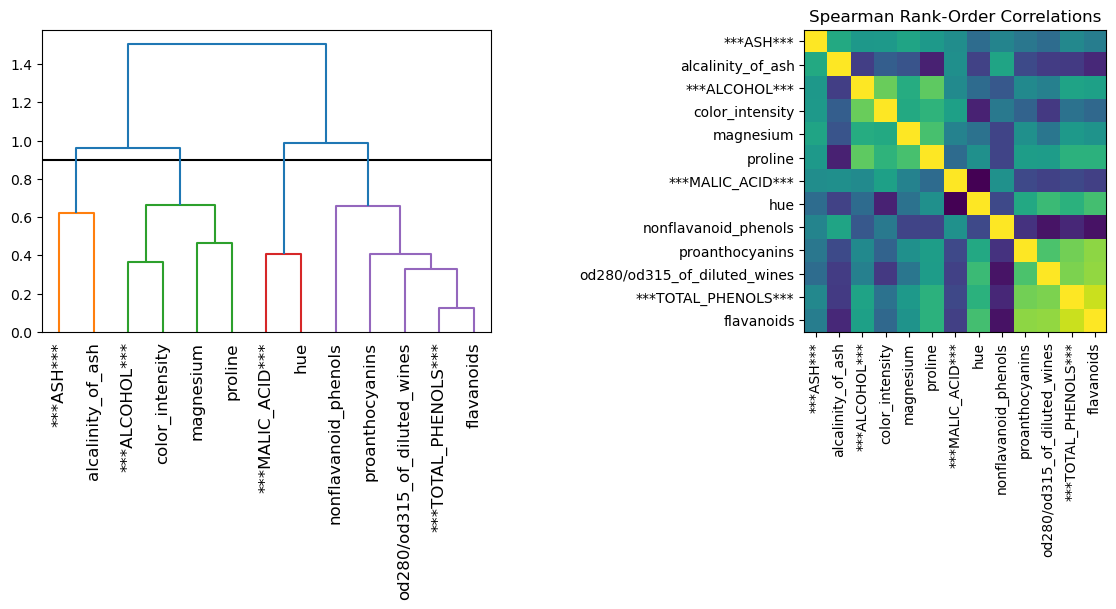

In [12]:
# Recall that we can use heirarchical clustering to find correlations in the X columns.  This allows us to see which
# features might actually be redundant.  We can then simply choose a single feature from each cluster to put in the model
# and then compare models with a different number of clusters or selections.

# Observe that proanthocyanins - flavanoids are highly correlated.
selected_features, cluster_id_to_feature_ids, _ = InspectData.cluster_collinear(
    X=X_train,
    feature_names=X.columns,
    t=0.9,
    figsize=(12,6),
    display=True # We can change this to False so we don't have these plots 
)

In [31]:
from sklearn.feature_selection import SelectFromModel
from pychemauth.preprocessing.feature_selection import CollinearFeatureSelector

def lookup(feature_idx, column_names=X.columns):
    if 'l' in column_names[feature_idx].lower():
        return 'Contains letter L'
    else:
        return 'No letter L'
    
se = SelectFromModel(
    estimator=CollinearFeatureSelector(
        t=0.9, 
        seed=42, 
        minimize_label_entropy=True, 
        kwargs={"lookup":lookup, "n_restarts":5, "max_iters":100, "T":1.0}
    ),
    threshold=0.5,
    prefit=False,
)

In [32]:
se.fit(X_train)

MC Steps: 100%|█████████████████████████████| 100/100 [00:00<00:00, 5168.26it/s]

MC Steps: 100%|█████████████████████████████| 100/100 [00:00<00:00, 5460.91it/s]

MC Steps: 100%|█████████████████████████████| 100/100 [00:00<00:00, 6236.42it/s]

MC Steps: 100%|█████████████████████████████| 100/100 [00:00<00:00, 6699.31it/s]

Restarts: 100%|███████████████████████████████████| 5/5 [00:00<00:00, 45.73it/s]


SelectFromModel(estimator=<pychemauth.preprocessing.feature_selection.CollinearFeatureSelector object at 0x7fbd30f25950>,
                threshold=0.5)

In [33]:
# The underlying estimator stores feature_importances_ as [0 (ignored), 1 (included)].
X.columns[np.asarray(se.estimator_.feature_importances_, dtype=bool)]

Index(['malic_acid', 'alcalinity_of_ash', 'nonflavanoid_phenols',
       'color_intensity'],
      dtype='object')

In [25]:
# The SelectFromModel has a more natural way of accessing which features are retained.
X.columns[se.get_support()]

Index(['malic_acid', 'alcalinity_of_ash', 'nonflavanoid_phenols',
       'color_intensity'],
      dtype='object')

In [34]:
# The selector can transform your data automatically, so you can include it in your pipeline.
se.transform(X_train)

array([[-0.63562119, -1.22021226, -0.16895084, -0.16687654],
       [-0.76274543,  0.85027423, -0.58837427,  0.30422622],
       [-0.51757725, -1.04274199, -0.16895084, -0.08122149],
       [-0.55389846, -1.07232037, -0.58837427,  0.2613987 ],
       [ 0.81722724,  0.55449045,  0.75378069,  1.46913485],
       [ 0.04540151, -0.03707712,  1.00543474,  2.10298177],
       [-1.04423481, -0.83569334, -1.84664453, -0.91635819],
       [ 0.70826361,  1.29394991, -1.17556706,  1.54622439],
       [-0.39953332, -0.7469582 ,  0.25047258,  0.56119136],
       [-0.63562119, -1.66388794, -0.58837427,  0.0900886 ],
       [-0.91711057,  1.17563639,  0.50212663, -1.3917437 ],
       [-0.56297877, -0.03707712,  0.08270321, -1.25469563],
       [ 1.49824995, -1.90051496, -1.34333643,  0.04726108],
       [-0.48125604,  0.25870666, -0.84002832,  0.04726108],
       [ 1.09871663,  0.55449045, -1.59499048,  0.00443356],
       [-0.46309544, -0.33286091,  1.34097348, -1.10908205],
       [-0.64470149,  1.

JSD
---

Letting the Data Decide
---

In [ ]:
# pipeline with different feature selectors inside a gridsearchCV as grid_params